# Running the NetworkSedimentTransporter from a shapefile of a river network

<img align="right" style="margin:0 0 20px 20px" width="25%" height="25%" src="https://csdms.colorado.edu/csdms_wiki/images/OpenEarthscape_logo.png">

Supported by NSF to Pfeiffer, Czuba, plus OpenEarthscape

Some links to NST notebooks. \

Link to original NST JOSS paper

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

from landlab.io import read_shapefile

from landlab.components import (
    FlowDirectorSteepest,
    NetworkSedimentTransporter,
    BedParcelInitializerDepth,
)

from landlab.grid.network import NetworkModelGrid

from landlab.io import esri_ascii, read_esri_ascii
from landlab.plot.graph import plot_links, plot_nodes
from landlab.plot.imshow import imshow_grid
from landlab.plot import plot_network_and_parcels

OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1

In [2]:
# Create Network Model Grid from shapefile
link_shapefile = os.path.join(os.getcwd (), ("hugo_links6.shp"))
points_shapefile = os.path.join(os.getcwd(), ("hugo_nodes.shp"))

grid = read_shapefile(
    link_shapefile,
    points_shapefile = points_shapefile,
    node_fields = ["Elev_m", "DArea_m2"],
    link_fields = ["Chan_slope", "Shape_Leng","DA_aprx_m2"],
    link_field_conversion = {"Chan_slope":"channel_slope", "Shape_Leng":"reach_length","DA_aprx_m2":"drainage_area"}, # maps from shapefile field names to standard landlab variables ## 
    node_field_conversion = {"DArea_m2": "drainage_area", "Elev_m": "topographic__elevation"},
    threshold = 10,
    )

grid.at_node["topographic__elevation"]=grid.at_node["topographic__elevation"].astype(float)
grid.at_node["bedrock__elevation"] = grid.at_node["topographic__elevation"].copy()

rm_grid, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rm_grid.status_at_node[rm_grid.nodes_at_right_edge] = rm_grid.BC_NODE_IS_FIXED_VALUE
rm_grid.status_at_node[np.isclose(z, -9999.0)] = rm_grid.BC_NODE_IS_CLOSED

/tmp/ipykernel_187802/1284011546.py:21: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rm_grid, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


Note that the indexing will not match the ordering of the shapefile IDs. Landlab re-orders the links/nodes spatially, starting with the grid element at the lower left and working up. See [this Landlab tutorial](https://landlab.csdms.io/tutorials/grids/diverse_grid_classes.html) for more details. 


XXXXX plot grid to show it...

#### Assign variables based on hydraulic geom scaling

In [3]:
# Approximately Scott Creek, CA hydraulic geometry relations 

grid.at_link["channel_width"] = 0.0028 * (grid.at_link['drainage_area'])**(0.49)# m

grid.at_link["flow_depth"] = 0.008 * (grid.at_link['drainage_area'])**(0.32)# m


INSERT a code block here inspecting the grid. 

Remind users to check for reasonable hydraulic geometry relationships and network geometry. Beware very short links. Beware links with very low or very high slope.

Now we make parcels

In [4]:
initialize_parcels = BedParcelInitializerDepth(grid,
                                          flow_depth_at_link = grid.at_link["flow_depth"],
                                          tau_c_50=0.045,
                                          tau_c_multiplier = 1/0.28, #Scott Ck ratio
                                          median_number_of_starting_parcels= 100,
                                          extra_parcel_attributes = ['inception']
                                          )

parcels = initialize_parcels()


In [5]:
# code block inspecting parcels -- D50, min/max, parcel volume
D50 = parcels.calc_aggregate_value(xr.Dataset.median, "D", at="link", fill_value=0.0) 

/opt/tljh/user/envs/csdms/lib/python3.12/site-packages/xarray/core/dataset.py:4802: UserWarning: No index created for dimension element_id because variable element_id is not a coordinate. To create an index for element_id, please first call `.set_coords('element_id')` on this object.
  warnings.warn(


In [6]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

nst = NetworkSedimentTransporter(
    grid,
    parcels,
    fd,
    active_layer_method = "Constant10cm",
)

timesteps = 10
dt = 60*60*24 # seconds

for t in range(0, (timesteps*dt), dt):

    nst.run_one_step(dt)



/opt/tljh/user/envs/csdms/lib/python3.12/site-packages/landlab/plot/network_sediment_transporter/plot_network_and_parcels.py:374: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


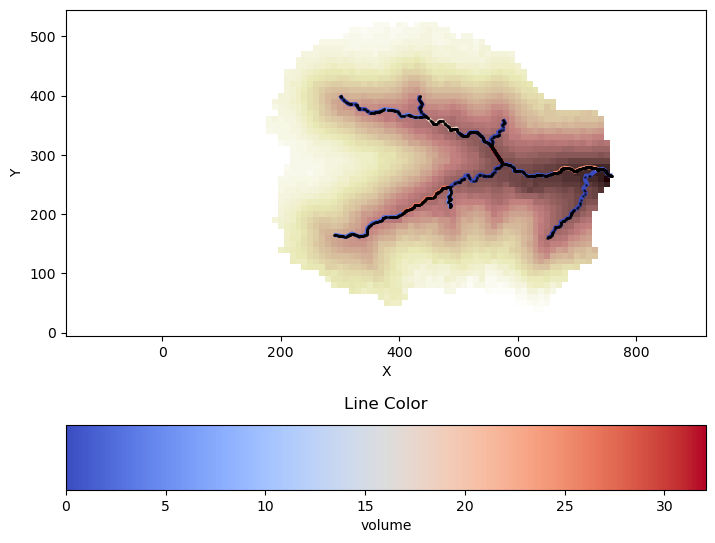

In [7]:
plt.figure("DEM_and_Network")

imshow_grid(
    rm_grid,
    "topographic__elevation",
    color_for_closed=None,
    allow_colorbar=False,
)

plot_network_and_parcels(
    grid,
    parcels,
    parcel_time_index=0,
    link_attribute=('sediment_total_volume'),
    parcel_alpha=0.5,
    network_linewidth= 3,
    link_attribute_title= "volume",
    network_cmap= "coolwarm",
    fig=plt.figure("DEM_and_Network"),
    )

make sure that somewhere we show them how to sort by drainage area